# Synthetic Core Tests

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
import xray_source as src
import xray_attenuation as att

%matplotlib inline

## Functions

In [2]:
def beam_to_pixel(ref, kVp="ref", mA="ref", s="ref"):
    if kVp == "ref":
        kVp_val = ref['tube']['kVp']
    else:
        kVp_val = kVp
    if mA == "ref":
        mA_val = ref['tube']['mA']
    else:
        mA_val = mA
    if s == "ref":
        s_val = ref['tube']['s']
    else:
        s_val = s
    
    ## Calculate Source Spectrum
    source = src.spectrum(ref['tube']['Zsrc'], kVp_val, mA_val, s_val, 
                          ref['tube']['theta_in'], ref['tube']['theta_out'], ref['tube']['dE'])

    ## Calculate mu_rho values 
    mu_rho_Cu = att.calc_mu_rho('Cu', ref['comps'], ref['rhos'], source[:,0])
    mu_rho_Air = att.calc_mu_rho('Air', ref['comps'], ref['rhos'], source[:,0])
    
    ## Solid Angle of Beam
    a_side = ref['geom']['px_size']
    b_side = ref['geom']['px_size']
    omega_src = att.calc_omega_pyramid(a_side, b_side, ref['geom']['src_ht'])
    source[:,1] = omega_src * source[:,1]

    ## Filtered Beam
    filtered, _ = att.attenuate(source, mu_rho_Cu, ref['tube']['Cu'])
    beam, _ = att.attenuate(filtered, mu_rho_Air, ref['geom']['src_ht'])
    return beam

In [3]:
def add_prop_labels(axis, x_pos, y_pos, ref, kVp="ref", mA="ref", s="ref"):
    text_str = 'Z = {:.0f}'.format(ref['tube']['Zsrc'])
    if kVp is not None:
        if kVp == "ref":
            kVp_val = ref['tube']['kVp']
        else:
            kVp_val = kVp
        text_str = text_str + '\nkVp = {:.2f}'.format(kVp_val)
    if mA is not None:
        if mA == "ref":
            mA_val = ref['tube']['mA']
        else:
            mA_val = mA
        text_str = text_str + '\nmA = {:.2f}'.format(mA_val)   
    if s is not None:
        if s == "ref":
            s_val = ref['tube']['s']
        else:
            s_val = s
        text_str = text_str + '\ns = {:.2f}'.format(s_val)
    text_str = text_str + '\nCu filter = {:.2f} cm'.format(ref['tube']['Cu'])
    
    boxprops = dict(boxstyle='square', facecolor='white', alpha=1.0)
    axis.text(x_pos, y_pos, text_str, transform=axis.transAxes, bbox=boxprops)
    return

In [4]:
def mat_label(material, ref):
    return '{} ({:.2f} g/cc)'.format(material, ref['rhos'][material])

## Properties

In [16]:
## Originally used 1.50 g/cc for clay and carb, 0.05cm for Cu_thickness

rhos = {'Be': 1.848, 'Pd': 12.02, 'Cu': 8.92, 
        'Air': 0.001205, 'Clay': 1.50, 'Carb': 1.50, 'Basalt': 3.00, 'Granite': 2.75}

comps = {'Be': {4: 1.00}, 'Pd': {46: 1.00}, 'Cu': {29: 1.00},
         'Air': {6: (0.0124/100.0), 7: (75.5268/100.0), 
                 8: (23.1781/100.0), 18: (1.2827/100.0)},
         'Clay': {8: 0.474, 11: 0.040, 12: 0.021, 13: 0.084, 14: 0.250, 
                  19: 0.025, 20: 0.029, 22: 0.005, 25: 0.007, 26: 0.065},
         'Carb': {8: 0.598, 11: 0.020, 12: 0.004, 13: 0.020, 14: 0.032, 
                 19: 0.003, 20: 0.313, 22: 0.001, 25: 0.001, 26: 0.009}, 
         'Basalt': {8: 0.430, 11: 0.029, 12: 0.044, 13: 0.087, 14: 0.237, 
                 19: 0.008, 20: 0.066, 22: 0.009, 25: 0.002, 26: 0.085},
         'Granite': {8: 0.486, 11: 0.028, 12: 0.006, 13: 0.077, 14: 0.322, 
                 19: 0.033, 20: 0.016, 22: 0.002, 25: 0.001, 26: 0.027}}

geom = {'nrows': 1550, 'ncols': 1032, 'px_size': 0.0099, 
        'radius': 3.4, 'core_type': 'WR', 'core_ht': 0.5, 'src_ht': 65.0}

tube = {'Zsrc': 74, 'theta_in': 78.0, 'theta_out': 12.0, 'dE': 0.5, 
        'kVp': 120.0, 'mA': 1.0, 's': 1.0, 'Cu': 0.01}

core = {'n_layers': 1500, 'p_L2': 0.3, 'p_IRD': 0.05, 'p_granite': 0.3, 
        'mu_carb_L1': 0.2, 'sd_carb_L1': 0.2, 'mu_carb_L2': 0.8, 'sd_carb_L2': 0.2, 
        'mu_t_IRD': 1.5, 'sd_t_IRD': 0.3}

ref = {'rhos': rhos, 'comps': comps, 'geom': geom, 'tube': tube, 'core': core}

##############################################################################

ref['core']['t_ref'] = 2*ref['geom']['radius']
if ref['geom']['core_type'] == 'HR':
    ref['core']['t_ref'] = 1*ref['geom']['radius']

##############################################################################

kVps = np.arange(60.0, 121.0, 1.0)
mAs = np.arange(0.20, 1.01, 0.01)
secs = np.arange(0.20, 1.01, 0.01)

## kVp vs Counts

In [6]:
## Calculations

beam_kVp_60 = beam_to_pixel(ref, kVp=60.0)
beam_kVp_80 = beam_to_pixel(ref, kVp=80.0)
beam_kVp_100 = beam_to_pixel(ref, kVp=100.0)
beam_kVp_120 = beam_to_pixel(ref, kVp=120.0)

kVp_vals = []
kVp_cts = []
for i, kVp_val in enumerate(kVps):
    beam_i = beam_to_pixel(ref, kVp=kVp_val)
    beam_cts = np.sum(beam_i)
    kVp_vals.append(kVp_val)
    kVp_cts.append(beam_cts)

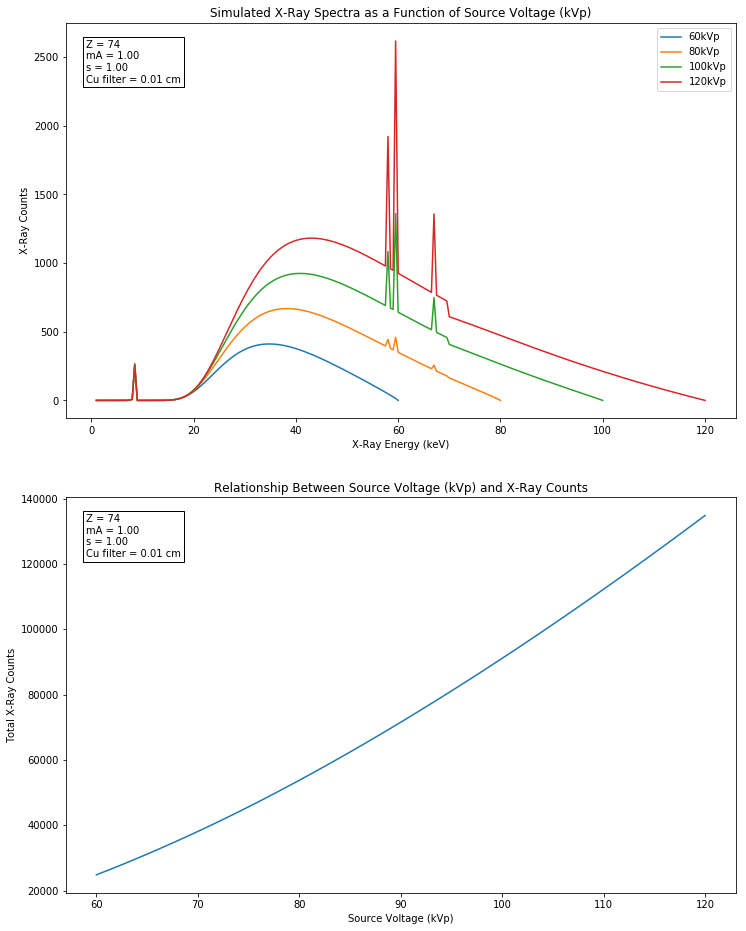

In [7]:
## Plots

n = 2
width = 12
height = 8
fig = plt.figure(figsize=(width, height*n))
ax1 = fig.add_subplot(211)
ax1.plot(beam_kVp_60[:,0], beam_kVp_60[:,1], label='60kVp')
ax1.plot(beam_kVp_80[:,0], beam_kVp_80[:,1], label='80kVp')
ax1.plot(beam_kVp_100[:,0], beam_kVp_100[:,1], label='100kVp')
ax1.plot(beam_kVp_120[:,0], beam_kVp_120[:,1], label='120kVp')
ax1.set_xlabel('X-Ray Energy (keV)')
ax1.set_ylabel('X-Ray Counts')
ax1.set_title('Simulated X-Ray Spectra as a Function of Source Voltage (kVp)')
add_prop_labels(ax1, 0.03, 0.85, ref, kVp=None)
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(kVp_vals, kVp_cts)
ax2.set_xlabel('Source Voltage (kVp)')
ax2.set_ylabel('Total X-Ray Counts')
ax2.set_title('Relationship Between Source Voltage (kVp) and X-Ray Counts')
add_prop_labels(ax2, 0.03, 0.85, ref, kVp=None)

plt.show()

## mA vs Cts

In [8]:
## Calculations

beam_mA_0p4 = beam_to_pixel(ref, mA=0.40)
beam_mA_0p6 = beam_to_pixel(ref, mA=0.60)
beam_mA_0p8 = beam_to_pixel(ref, mA=0.80)
beam_mA_1p0 = beam_to_pixel(ref, mA=1.00)

mA_vals = []
mA_cts = []
for i, mA_val in enumerate(mAs):
    beam_i = beam_to_pixel(ref, mA=mA_val)
    beam_cts = np.sum(beam_i)
    mA_vals.append(mA_val)
    mA_cts.append(beam_cts)

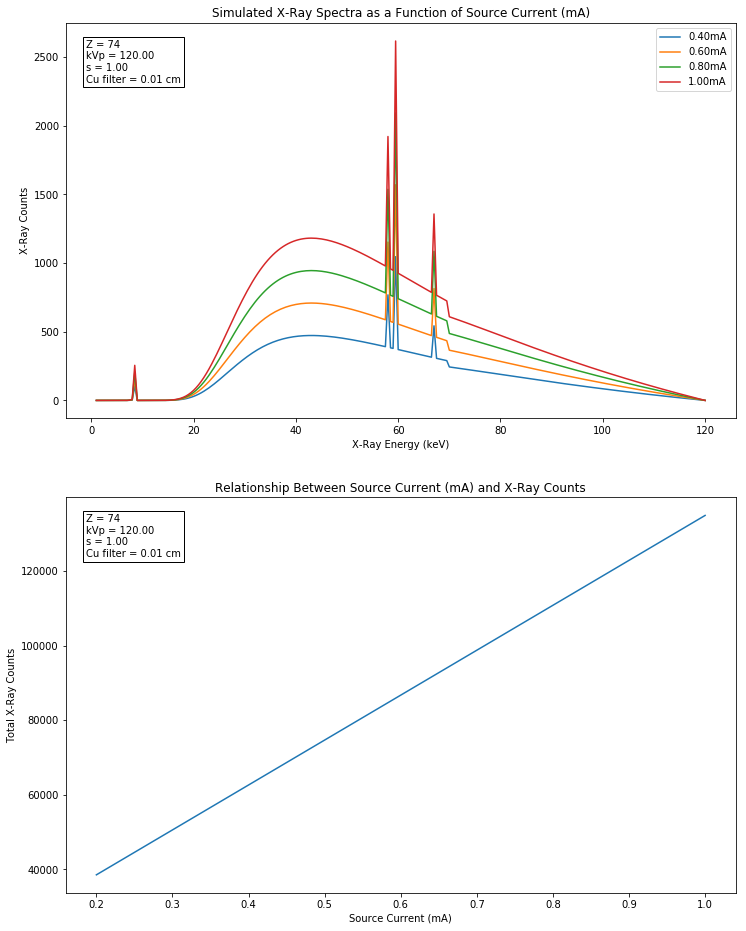

In [9]:
## Plots

n = 2
width = 12
height = 8
fig = plt.figure(figsize=(width,height*n))
ax1 = fig.add_subplot(211)
ax1.plot(beam_mA_0p4[:,0], beam_mA_0p4[:,1], label='0.40mA')
ax1.plot(beam_mA_0p6[:,0], beam_mA_0p6[:,1], label='0.60mA')
ax1.plot(beam_mA_0p8[:,0], beam_mA_0p8[:,1], label='0.80mA')
ax1.plot(beam_mA_1p0[:,0], beam_mA_1p0[:,1], label='1.00mA')
ax1.set_xlabel('X-Ray Energy (keV)')
ax1.set_ylabel('X-Ray Counts')
ax1.set_title('Simulated X-Ray Spectra as a Function of Source Current (mA)')
add_prop_labels(ax1, 0.03, 0.85, ref, mA=None)
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(mA_vals, mA_cts)
ax2.set_xlabel('Source Current (mA)')
ax2.set_ylabel('Total X-Ray Counts')
ax2.set_title('Relationship Between Source Current (mA) and X-Ray Counts')
add_prop_labels(ax2, 0.03, 0.85, ref, mA=None)

plt.show()

## Exposure vs Cts

In [10]:
## Calculations

beam_s_0p4 = beam_to_pixel(ref, s=0.40)
beam_s_0p6 = beam_to_pixel(ref, s=0.60)
beam_s_0p8 = beam_to_pixel(ref, s=0.80)
beam_s_1p0 = beam_to_pixel(ref, s=1.00)

s_vals = []
s_cts = []
for i, s_val in enumerate(secs):
    beam_i = beam_to_pixel(ref, s=s_val)
    beam_cts = np.sum(beam_i)
    s_vals.append(s_val)
    s_cts.append(beam_cts)

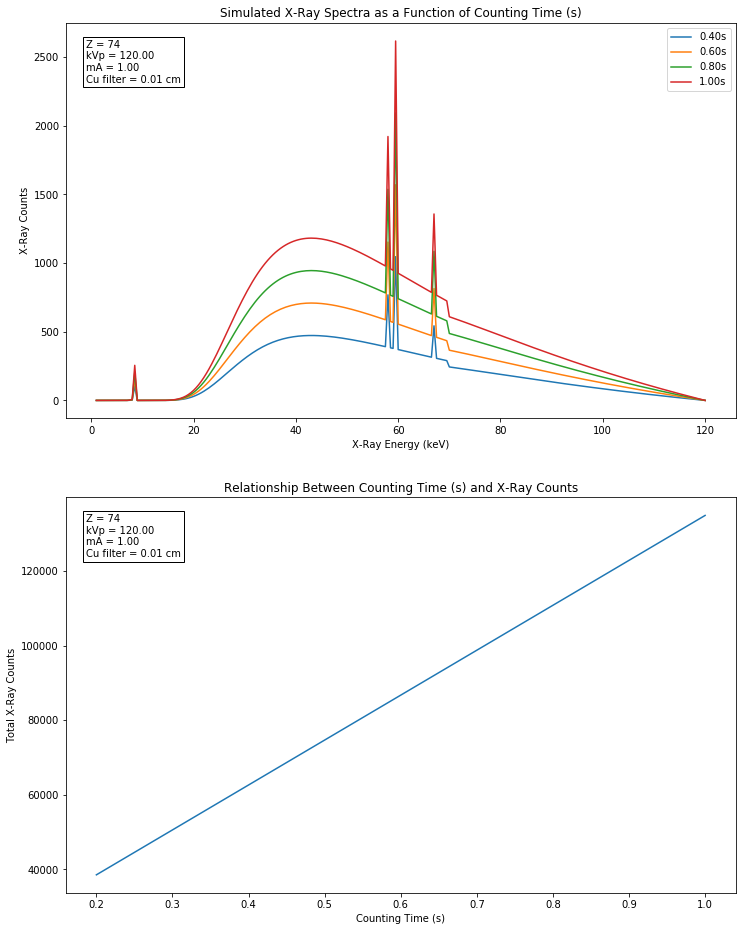

In [11]:
## Plots

n = 2
width = 12
height = 8
fig = plt.figure(figsize=(width,height*n))
ax1 = fig.add_subplot(211)
ax1.plot(beam_s_0p4[:,0], beam_s_0p4[:,1], label='0.40s')
ax1.plot(beam_s_0p6[:,0], beam_s_0p6[:,1], label='0.60s')
ax1.plot(beam_s_0p8[:,0], beam_s_0p8[:,1], label='0.80s')
ax1.plot(beam_s_1p0[:,0], beam_s_1p0[:,1], label='1.00s')
ax1.set_xlabel('X-Ray Energy (keV)')
ax1.set_ylabel('X-Ray Counts')
ax1.set_title('Simulated X-Ray Spectra as a Function of Counting Time (s)')
add_prop_labels(ax1, 0.03, 0.85, ref, s=None)
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(s_vals, s_cts)
ax2.set_xlabel('Counting Time (s)')
ax2.set_ylabel('Total X-Ray Counts')
ax2.set_title('Relationship Between Counting Time (s) and X-Ray Counts')
add_prop_labels(ax2, 0.03, 0.85, ref, s=None)
plt.show()

## kVp vs mA vs exposure Contour Plots

In [12]:
## Calculations

## Need contour plots of (kVp, mA, Cts) and (kVp, s, Cts)
n_kVps = len(kVps)
n_mAs = len(mAs)
n_secs = len(secs)

kVp_mA_cts = np.zeros(shape=(n_kVps*n_mAs, 3))
kVp_s_cts = np.zeros(shape=(n_kVps*n_secs, 3))
mA_s_cts = np.zeros(shape=(n_mAs*n_secs, 3))

for i, kVp_val in enumerate(kVps):
    for j, mA_val in enumerate(mAs):
        beam_i = beam_to_pixel(ref, kVp=kVp_val, mA=mA_val)
        beam_cts = np.sum(beam_i)
        row = i*n_mAs + j
        kVp_mA_cts[row,0] = kVp_val
        kVp_mA_cts[row,1] = mA_val
        kVp_mA_cts[row,2] = beam_cts

for i, kVp_val in enumerate(kVps):
    for j, s_val in enumerate(secs):
        beam_i = beam_to_pixel(ref, kVp=kVp_val, s=s_val)
        beam_cts = np.sum(beam_i)
        row = i*n_secs + j
        kVp_s_cts[row,0] = kVp_val
        kVp_s_cts[row,1] = s_val
        kVp_s_cts[row,2] = beam_cts
        
for i, mA_val in enumerate(mAs):
    for j, s_val in enumerate(secs):
        beam_i = beam_to_pixel(ref, mA=mA_val, s=s_val)
        beam_cts = np.sum(beam_i)
        row = i*n_secs + j
        mA_s_cts[row,0] = mA_val
        mA_s_cts[row,1] = s_val
        mA_s_cts[row,2] = beam_cts

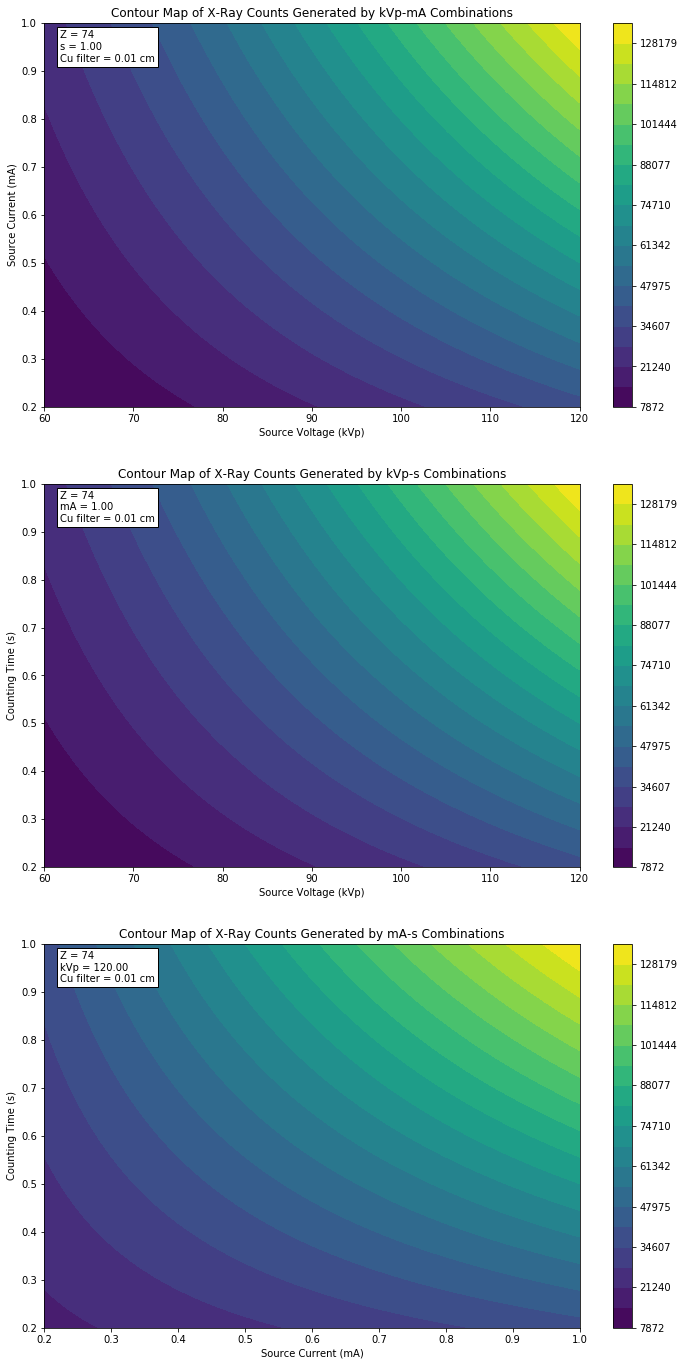

In [13]:
## Plots

cont_vals = np.linspace(np.min(kVp_mA_cts[:,2]), np.max(kVp_mA_cts[:,2]), 20)

n = 3
width = 12
height = 8
fig = plt.figure(figsize=(width, height*n))
ax1 = fig.add_subplot(311)
tri1 = ax1.tricontourf(kVp_mA_cts[:,0],kVp_mA_cts[:,1],kVp_mA_cts[:,2], levels=cont_vals)
ax1.set_xlabel('Source Voltage (kVp)')
ax1.set_ylabel('Source Current (mA)')
ax1.set_title('Contour Map of X-Ray Counts Generated by kVp-mA Combinations')
add_prop_labels(ax1, 0.03, 0.90, ref, kVp=None, mA=None)
fig.colorbar(tri1, ax=ax1)

ax2 = fig.add_subplot(312)
tri2 = ax2.tricontourf(kVp_s_cts[:,0],kVp_s_cts[:,1],kVp_s_cts[:,2], levels=cont_vals)
ax2.set_xlabel('Source Voltage (kVp)')
ax2.set_ylabel('Counting Time (s)')
ax2.set_title('Contour Map of X-Ray Counts Generated by kVp-s Combinations')
add_prop_labels(ax2, 0.03, 0.90, ref, kVp=None, s=None)
fig.colorbar(tri2, ax=ax2)

ax3 = fig.add_subplot(313)
tri3 = ax3.tricontourf(mA_s_cts[:,0],mA_s_cts[:,1],mA_s_cts[:,2], levels=cont_vals)
ax3.set_xlabel('Source Current (mA)')
ax3.set_ylabel('Counting Time (s)')
ax3.set_title('Contour Map of X-Ray Counts Generated by mA-s Combinations')
add_prop_labels(ax3, 0.03, 0.90, ref, mA=None, s=None)
fig.colorbar(tri3, ax=ax3)
plt.show()

## keV vs X-Ray Penetration

In [17]:
## Calculations

beam = beam_to_pixel(ref)

mu_rho_Clay = att.calc_mu_rho('Clay', ref['comps'], ref['rhos'], beam[:,0])
mu_rho_Carb = att.calc_mu_rho('Carb', ref['comps'], ref['rhos'], beam[:,0])
mu_rho_Basalt = att.calc_mu_rho('Basalt', ref['comps'], ref['rhos'], beam[:,0])
mu_rho_Granite = att.calc_mu_rho('Granite', ref['comps'], ref['rhos'], beam[:,0])
    
transmit_Clay, _ = att.attenuate(beam, mu_rho_Clay, ref['core']['t_ref'])
transmit_Carb, _ = att.attenuate(beam, mu_rho_Carb, ref['core']['t_ref'])
transmit_Basalt, _ = att.attenuate(beam, mu_rho_Basalt, ref['core']['t_ref'])
transmit_Granite, _ = att.attenuate(beam, mu_rho_Granite, ref['core']['t_ref'])

frac_trans_Clay = np.divide(transmit_Clay[:,1], beam[:,1], out=np.zeros_like(beam[:,1]), where=beam[:,1]!=0)
frac_trans_Carb = np.divide(transmit_Carb[:,1], beam[:,1], out=np.zeros_like(beam[:,1]), where=beam[:,1]!=0)
frac_trans_Basalt = np.divide(transmit_Basalt[:,1], beam[:,1], out=np.zeros_like(beam[:,1]), where=beam[:,1]!=0)
frac_trans_Granite = np.divide(transmit_Granite[:,1], beam[:,1], out=np.zeros_like(beam[:,1]), where=beam[:,1]!=0)

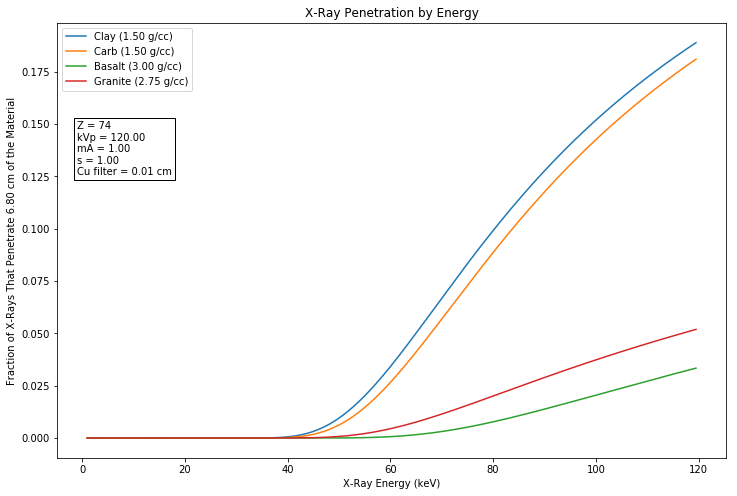

In [19]:
## Plots

n = 1
width = 12
height = 8
fig = plt.figure(figsize=(width, height*n))
ax1 = fig.add_subplot(111)
ax1.plot(beam[:-1,0], frac_trans_Clay[:-1], label=mat_label('Clay', ref))
ax1.plot(beam[:-1,0], frac_trans_Carb[:-1], label=mat_label('Carb', ref))
ax1.plot(beam[:-1,0], frac_trans_Basalt[:-1], label=mat_label('Basalt', ref))
ax1.plot(beam[:-1,0], frac_trans_Granite[:-1], label=mat_label('Granite', ref))
ax1.set_xlabel('X-Ray Energy (keV)')
ax1.set_ylabel('Fraction of X-Rays That Penetrate {:.2f} cm of the Material'.format(ref['core']['t_ref']))
ax1.set_title('X-Ray Penetration by Energy')
add_prop_labels(ax1, 0.03, 0.65, ref)
ax1.legend()
plt.show()

## kVp vs X-Ray Penetration

In [21]:
## Calculations

kVp_arr = []
trans_Clay_arr = []
trans_Carb_arr = []
trans_Basalt_arr = []
trans_Granite_arr = []
frac_Clay_arr = []
frac_Carb_arr = []
frac_Basalt_arr = []
frac_Granite_arr = []
rel_Clay_arr = []
rel_Carb_arr = []
rel_Basalt_arr = []
rel_Granite_arr = []

for kVp_val in kVps:
    beam_i = beam_to_pixel(ref, kVp=kVp_val)
    beam_cts = np.sum(beam_i)
    
    mu_rho_Clay = att.calc_mu_rho('Clay', ref['comps'], ref['rhos'], beam_i[:,0])
    mu_rho_Carb = att.calc_mu_rho('Carb', ref['comps'], ref['rhos'], beam_i[:,0])
    mu_rho_Basalt = att.calc_mu_rho('Basalt', ref['comps'], ref['rhos'], beam_i[:,0])
    mu_rho_Granite = att.calc_mu_rho('Granite', ref['comps'], ref['rhos'], beam_i[:,0])
    
    transmit_Clay_i, _ = att.attenuate(beam_i, mu_rho_Clay, ref['core']['t_ref'])
    transmit_Carb_i, _ = att.attenuate(beam_i, mu_rho_Carb, ref['core']['t_ref'])
    transmit_Basalt_i, _ = att.attenuate(beam_i, mu_rho_Basalt, ref['core']['t_ref'])
    transmit_Granite_i, _ = att.attenuate(beam_i, mu_rho_Granite, ref['core']['t_ref'])
    
    transmit_Clay_cts = np.sum(transmit_Clay_i[:,1])
    transmit_Carb_cts = np.sum(transmit_Carb_i[:,1])
    transmit_Basalt_cts = np.sum(transmit_Basalt_i[:,1])
    transmit_Granite_cts = np.sum(transmit_Granite_i[:,1])
    
    fraction_Clay = transmit_Clay_cts / beam_cts
    fraction_Carb = transmit_Carb_cts / beam_cts
    fraction_Basalt = transmit_Basalt_cts / beam_cts
    fraction_Granite = transmit_Granite_cts / beam_cts
    
    relative_Clay = transmit_Clay_cts / transmit_Clay_cts
    relative_Carb = transmit_Carb_cts / transmit_Clay_cts
    relative_Basalt = transmit_Basalt_cts / transmit_Clay_cts
    relative_Granite = transmit_Granite_cts / transmit_Clay_cts
    
    kVp_arr.append(kVp_val)
    
    trans_Clay_arr.append(transmit_Clay_cts)
    trans_Carb_arr.append(transmit_Carb_cts)
    trans_Basalt_arr.append(transmit_Basalt_cts)
    trans_Granite_arr.append(transmit_Granite_cts)
    
    frac_Clay_arr.append(fraction_Clay)
    frac_Carb_arr.append(fraction_Carb)
    frac_Basalt_arr.append(fraction_Basalt)
    frac_Granite_arr.append(fraction_Granite)
    
    rel_Clay_arr.append(relative_Clay)
    rel_Carb_arr.append(relative_Carb)
    rel_Basalt_arr.append(relative_Basalt)
    rel_Granite_arr.append(relative_Granite)

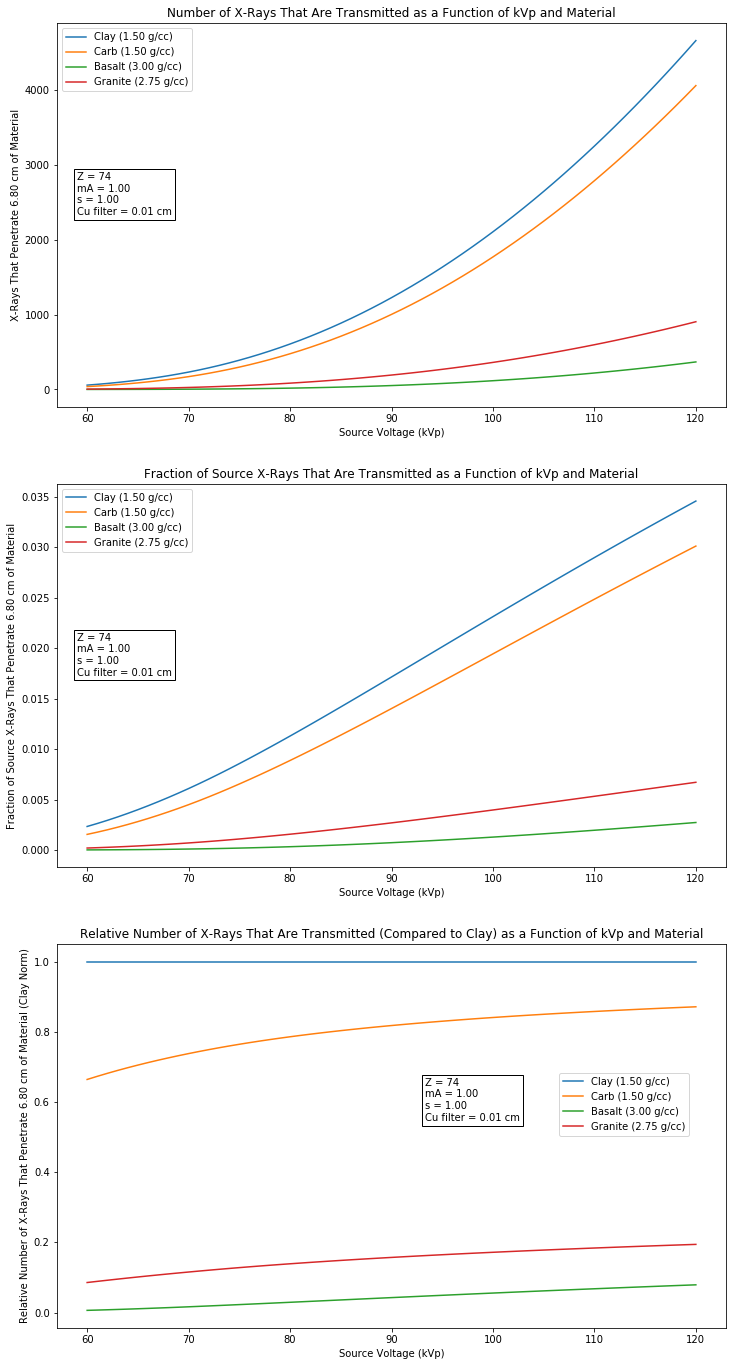

In [22]:
## Plots

n = 3
width = 12
height = 8
fig = plt.figure(figsize=(width, height*n))
ax1 = fig.add_subplot(311)
ax1.plot(kVp_arr, trans_Clay_arr, label=mat_label('Clay', ref))
ax1.plot(kVp_arr, trans_Carb_arr, label=mat_label('Carb', ref))
ax1.plot(kVp_arr, trans_Basalt_arr, label=mat_label('Basalt', ref))
ax1.plot(kVp_arr, trans_Granite_arr, label=mat_label('Granite', ref))
ax1.set_xlabel('Source Voltage (kVp)')
ax1.set_ylabel('X-Rays That Penetrate {:.2f} cm of Material'.format(ref['core']['t_ref']))
ax1.set_title('Number of X-Rays That Are Transmitted as a Function of kVp and Material')
add_prop_labels(ax1, 0.03, 0.50, ref, kVp=None)
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.plot(kVp_arr, frac_Clay_arr, label=mat_label('Clay', ref))
ax2.plot(kVp_arr, frac_Carb_arr, label=mat_label('Carb', ref))
ax2.plot(kVp_arr, frac_Basalt_arr, label=mat_label('Basalt', ref))
ax2.plot(kVp_arr, frac_Granite_arr, label=mat_label('Granite', ref))
ax2.set_xlabel('Source Voltage (kVp)')
ax2.set_ylabel('Fraction of Source X-Rays That Penetrate {:.2f} cm of Material'.format(ref['core']['t_ref']))
ax2.set_title('Fraction of Source X-Rays That Are Transmitted as a Function of kVp and Material')
add_prop_labels(ax2, 0.03, 0.50, ref, kVp=None)
ax2.legend()

ax3 = fig.add_subplot(313)
ax3.plot(kVp_arr, rel_Clay_arr, label=mat_label('Clay', ref))
ax3.plot(kVp_arr, rel_Carb_arr, label=mat_label('Carb', ref))
ax3.plot(kVp_arr, rel_Basalt_arr, label=mat_label('Basalt', ref))
ax3.plot(kVp_arr, rel_Granite_arr, label=mat_label('Granite', ref))
ax3.set_xlabel('Source Voltage (kVp)')
ax3.set_ylabel('Relative Number of X-Rays That Penetrate {:.2f} cm of Material (Clay Norm)'.format(ref['core']['t_ref']))
ax3.set_title('Relative Number of X-Rays That Are Transmitted (Compared to Clay) as a Function of kVp and Material')
add_prop_labels(ax3, 0.55, 0.54, ref, kVp=None)
ax3.legend(loc=(0.75, 0.50))
plt.show()

## Synthetic Core

In [23]:
def generate_synthetic_core(ref):
    ## Calculate total core thicknesses
    X_vals = np.arange(-ref['geom']['radius'], (ref['geom']['radius']+ref['geom']['px_size']), ref['geom']['px_size'])
    Zsq_vals = ref['geom']['radius']**2 - X_vals**2
    Zsq_filt = np.where(Zsq_vals < 0.0, 0.0, Zsq_vals)
    Z_vals = np.sqrt(Zsq_filt)

    thickness_vals = Z_vals
    if ref['geom']['core_type'] == 'WR':
        thickness_vals = 2*Z_vals

    ## Create 2D arrays for pseudo pixel positions
    t_clay = np.zeros(shape=(ref['core']['n_layers'], len(thickness_vals)))
    t_carb = np.zeros(shape=(ref['core']['n_layers'], len(thickness_vals)))
    t_basalt = np.zeros(shape=(ref['core']['n_layers'], len(thickness_vals)))
    t_granite = np.zeros(shape=(ref['core']['n_layers'], len(thickness_vals)))

    ## Create a synthetic core for each pixel
    for i in range(ref['core']['n_layers']):
        for j, t in enumerate(thickness_vals):
            IRD = np.random.rand(1)
            if (IRD <= ref['core']['p_IRD']):
                granite = np.random.rand(1)
                t_IRD = np.random.normal(ref['core']['mu_t_IRD'], ref['core']['sd_t_IRD'], 1)
                t_IRD = max(0.0, min(t, t_IRD))
                if (granite <= ref['core']['p_granite']):
                    t_basalt[i, j] = 0.0
                    t_granite[i, j] = t_IRD
                else:
                    t_basalt[i, j] = t_IRD
                    t_granite[i, j] = 0.0
            else:
                t_basalt[i, j] = 0.0
                t_granite[i, j] = 0.0

            L2 = np.random.rand(1)
            if (L2 <= ref['core']['p_L2']):
                carb_Li = np.random.normal(ref['core']['mu_carb_L2'], ref['core']['sd_carb_L2'], 1)
            else:
                carb_Li = np.random.normal(ref['core']['mu_carb_L1'], ref['core']['sd_carb_L1'], 1)

            carb_Li = max(0.0, min(1.0, carb_Li))
            t_clay[i, j] = (t - t_basalt[i, j] - t_granite[i, j])*(1.0 - carb_Li)
            t_carb[i, j] = (t - t_basalt[i, j] - t_granite[i, j])*(carb_Li)
            
    return (t_clay, t_carb, t_basalt, t_granite)

In [24]:
## Synthetic Core

t_vals = generate_synthetic_core(ref)

## Histogram Optimization

In [26]:
def simulate_histogram(t_vals, ref, kVp='ref', mA='ref', s='ref', n_bins=2**7):
    if kVp == "ref":
        kVp_val = ref['tube']['kVp']
    else:
        kVp_val = kVp
    if mA == "ref":
        mA_val = ref['tube']['mA']
    else:
        mA_val = mA
    if s == "ref":
        s_val = ref['tube']['s']
    else:
        s_val = s
    
    ## Calculate beam and mu*rho
    beam = beam_to_pixel(ref, kVp=kVp_val, s=s_val)
    mu_rho_Clay = att.calc_mu_rho('Clay', ref['comps'], ref['rhos'], beam[:,0])
    mu_rho_Carb = att.calc_mu_rho('Carb', ref['comps'], ref['rhos'], beam[:,0])
    mu_rho_Basalt = att.calc_mu_rho('Basalt', ref['comps'], ref['rhos'], beam[:,0])
    mu_rho_Granite = att.calc_mu_rho('Granite', ref['comps'], ref['rhos'], beam[:,0])

    ## Calculate x-ray attenuation for each
    t_clay = t_vals[0]
    t_carb = t_vals[1]
    t_basalt = t_vals[2]
    t_granite = t_vals[3]
    
    nrows, ncols = t_clay.shape
    cts = np.zeros(shape=(nrows, ncols))
    for i in range(nrows):
        for j in range(ncols):
            transmit_Clay, _ = att.attenuate(beam, mu_rho_Clay, t_clay[i,j])
            transmit_Carb, _ = att.attenuate(transmit_Clay, mu_rho_Carb, t_carb[i,j])
            transmit_Basalt, _ = att.attenuate(transmit_Carb, mu_rho_Basalt, t_basalt[i,j])
            transmit_Granite, _ = att.attenuate(transmit_Basalt, mu_rho_Granite, t_granite[i,j])
            cts[i,j] = np.sum(transmit_Granite[:,1])

    ## Round to integers
    cts = np.rint(cts)
    
    ## Create histogram
    max_val = np.amax(cts)
    hist_bins = np.linspace(0.0, 2**14, n_bins, endpoint=True)
    hist_bins = np.concatenate((hist_bins, np.array([max_val])), axis=0)
    hist_cts, _ = np.histogram(cts, hist_bins)
    
    return hist_bins, hist_cts

In [69]:
kVp1 = 120.0
s1 = 1.00
bins1, cts1 = simulate_histogram(t_vals, ref, kVp=kVp1, s=s1)

In [70]:
kVp2 = 100.0
s2 = 2.22
bins2, cts2 = simulate_histogram(t_vals, ref, kVp=kVp2, s=s2)

In [73]:
kVp3 = 80.0
s3 = 7.80
bins3, cts3 = simulate_histogram(t_vals, ref, kVp=kVp3, s=s3)

In [81]:
kVp4 = 60.0
s4 = 80.00
bins4, cts4 = simulate_histogram(t_vals, ref, kVp=kVp4, s=s4)

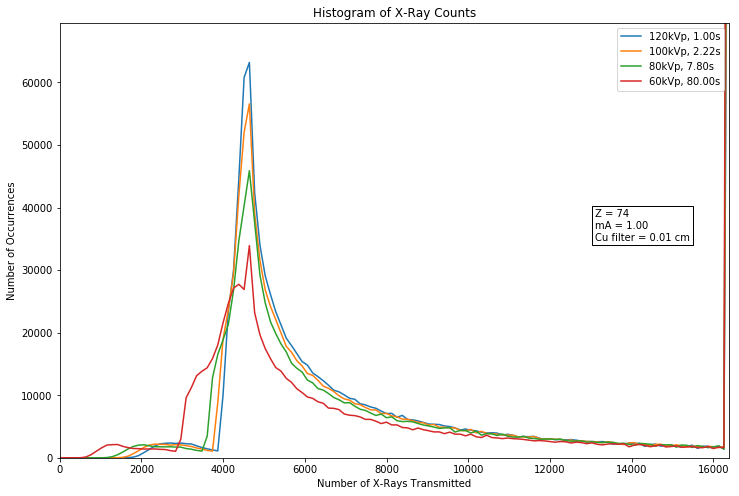

In [82]:
width=12
height=8
label_x=0.8
label_y=0.5

fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)
ax.plot(bins1[:-1], cts1, label='{:.0f}kVp, {:.2f}s'.format(kVp1,s1))
ax.plot(bins2[:-1], cts2, label='{:.0f}kVp, {:.2f}s'.format(kVp2,s2))
ax.plot(bins3[:-1], cts3, label='{:.0f}kVp, {:.2f}s'.format(kVp3,s3))
ax.plot(bins4[:-1], cts4, label='{:.0f}kVp, {:.2f}s'.format(kVp4,s4))
ax.set_xlim([0.0, 2**14])
ax.set_ylim([0.0, 1.1*np.amax(cts1[:-1])])
ax.set_xlabel('Number of X-Rays Transmitted')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Histogram of X-Ray Counts')
ax.legend()
add_prop_labels(ax, label_x, label_y, ref, kVp=None, s=None)
plt.show()